# Introduction

Author: Harneet Rishi

Purpose: Generate figures and analysis for Section 4 (Time-series analysis); Figures 4a and 4b

# Imports

## Modules/packages

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.stats.multitest as smm
from scipy.special import comb
from scipy.stats import hypergeom, pearsonr, mannwhitneyu, sem

import warnings
warnings.filterwarnings('ignore')

## Functions

In [3]:
def hypergeometric_test(k,N,K,n):
    num = comb(K,k)*comb((N-K),(n-k))
    den = comb(N,n)
    return num/den

In [4]:
def calc_pooled_var(n1, var1, n2, var2):
    pooled_var = np.sqrt( ((n1 - 1)*var1 + (n2-1)*var2) / (n1 + n2 - 2) )
    return pooled_var

In [5]:
def calc_cohens_d(mean_x, mean_y, pooled_var):
    cohens_d = (mean_x - mean_y) / pooled_var
    return abs(cohens_d)

## Data

### sgRNA annotations

In [6]:
df_sgRNA_info_update_3 = pd.read_csv('SourceData/APAHR007_v4_21-df_sgRNA_info_update_3.csv')
df_sgRNA_info_update_3.drop(labels = 'seq.1', inplace = True, axis = 1)
df_sgRNA_info_update_3.set_index(keys = 'seq', inplace = True, drop = False)
df_sgRNA_info_update_3.head(10)

,seq,pos,strand,category,product_name,gene_name_F2,bnumber_F2,Class(1:essential 2:noessential 3:unknown)
seq,,,,,,,,
agcggtaaaattcgtgtaat,agcggtaaaattcgtgtaat,923423,+,Promoter,,NaN,NaN,0
gcgagaaaccttattaacca,gcgagaaaccttattaacca,100609,+,Promoter,,NaN,NaN,0
ggcgtgccgatgggctacgg,ggcgtgccgatgggctacgg,3046225,-,Promoter,,NaN,NaN,0
gggctacggtggcccacacg,gggctacggtggcccacacg,3046214,-,Promoter,,NaN,NaN,0
agttgtatgatgcaactagt,agttgtatgatgcaactagt,4638701,-,Promoter,,NaN,NaN,0
cgtactgctcgggcccgaaa,cgtactgctcgggcccgaaa,2751592,+,Promoter,,NaN,NaN,0
ggaaaagttttgcgctatgt,ggaaaagttttgcgctatgt,2554,+,Promoter,,NaN,NaN,0
tagtccttccccttacggga,tagtccttccccttacggga,137014,-,Promoter,,NaN,NaN,0
tggttttatatacagtaaag,tggttttatatacagtaaag,2749746,-,Promoter,,NaN,NaN,0


In [7]:
len(df_sgRNA_info_update_3[(df_sgRNA_info_update_3['Class(1:essential 2:noessential 3:unknown)'] == 1) &
                          (df_sgRNA_info_update_3['bnumber_F2'] != 'b2651')]['gene_name_F2'].unique())

304

In [8]:
df_genomeInfo = pd.read_table('Annotations/genomeInfo.cgi.txt')
df_genomeInfo_dropdup = df_genomeInfo.drop_duplicates(['name'])
df_genomeInfo_dropdup.set_index(keys = 'sysName', inplace = True, drop = False)
df_genomeInfo_dropdup

,locusId,accession,GI,scaffoldId,start,stop,strand,sysName,name,desc,COG,COGFun,COGDesc,TIGRFam,TIGRRoles,GO,EC,ECDesc
sysName,,,,,,,,,,,,,,,,,,
b0001,14146,NP_414542.1,16127995.0,7023,190,255,+,b0001,thrL,thr operon leader peptide (NCBI),NaN,NaN,NaN,TIGR02077 thr operon leader peptide [thrL],Amino acid biosynthesis:Aspartate family,GO:0009088,NaN,NaN
b0002,14147,NP_414543.1,16127996.0,7023,337,2799,+,b0002,thrA,bifunctional aspartokinase I/homeserine dehydr...,COG527,E,Aspartokinases,TIGR00657 aspartate kinase,Amino acid biosynthesis:Aspartate family,"GO:0009067,GO:0016597,GO:0004072,GO:0004412",2.7.2.4,Aspartate kinase.
b0003,14148,NP_414544.1,16127997.0,7023,2801,3733,+,b0003,thrB,homoserine kinase (NCBI),COG83,E,Homoserine kinase,TIGR00191 homoserine kinase [thrB],Amino acid biosynthesis:Aspartate family,"GO:0006566,GO:0016310,GO:0004413,GO:0005524",2.7.1.39,Homoserine kinase.
b0004,14149,NP_414545.1,16127998.0,7023,3734,5020,+,b0004,thrC,threonine synthase (NCBI),COG498,E,Threonine synthase,TIGR00260 threonine synthase [thrC],Amino acid biosynthesis:Aspartate family,"GO:0009088,GO:0030170,GO:0004795",4.2.3.1,Threonine synthase.
b0005,14150,NP_414546.1,16127999.0,7023,5234,5530,+,b0005,yaaX,hypothetical protein (NCBI),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4399,18420,NP_418816.1,16132216.0,7023,4634719,4636143,+,b4399,creC,sensory histidine kinase in two-component regu...,COG642,T,Signal transduction histidine kinase,NaN,NaN,"GO:0007165,GO:0018106,GO:0016020,GO:0000155,GO...","2.7.13.3,2.7.3.-","Histidine kinase.,"
b4400,18421,NP_418817.1,16132217.0,7023,4636201,4637553,+,b4400,creD,inner membrane protein (NCBI),COG4452,V,Inner membrane protein involved in colicin E2 ...,NaN,NaN,NaN,NaN,NaN
b4401,18422,NP_418818.1,16132218.0,7023,4638329,4637613,-,b4401,arcA,DNA-binding response regulator in two-componen...,COG745,TK,Response regulators consisting of a CheY-like ...,NaN,NaN,"GO:0006355,GO:0000160,GO:0003677,GO:0000156",NaN,NaN


### Fitness values

In [9]:
df_sgRNA_counts_LR_withcounts_info = pd.read_csv('SourceData/APAHR021_3-df_sgRNA_counts_LR_withcounts_info.csv')
df_sgRNA_counts_LR_withcounts_info.drop(labels = 'seq.1', axis = 1, inplace = True)
df_sgRNA_counts_LR_withcounts_info.set_index(keys=  'seq', inplace = True, drop = False)
df_sgRNA_counts_LR_withcounts_info.drop(labels = ['gene_name'], inplace = True, axis = 1)
df_sgRNA_counts_LR_withcounts_info['gene_name_F2'] = df_sgRNA_info_update_3['gene_name_F2']
df_sgRNA_counts_LR_withcounts_info['bnumber_F2'] = df_sgRNA_info_update_3['bnumber_F2']
df_sgRNA_counts_LR_withcounts_info['Class(1:essential 2:noessential 3:unknown)'] = df_sgRNA_info_update_3['Class(1:essential 2:noessential 3:unknown)']
df_sgRNA_counts_LR_withcounts_info.head()

,seq,ET165_LB_ae_Br2_R1,ET165_LB_ae_Br2_R2,ET165_LB_ae_Br4_R1,ET165_LB_ae_Br4_R2,ET165_LB_ae_Br6_R1,ET165_LB_ae_Br6_R2,ET165_LB_ae_Br8_R1,ET165_LB_ae_Br8_R2,ET165_LB_ae_BrSat_R1,ET165_LB_ae_BrSat_R2,ET165_LB_ae_Cr2_R1,ET165_LB_ae_Cr2_R2,ET165_LB_ae_Cr4_R1,ET165_LB_ae_Cr4_R2,ET165_LB_ae_Cr6_R1,ET165_LB_ae_Cr6_R2,ET165_LB_ae_CrSat_R1,ET165_LB_ae_CrSat_R2,ET165_LB_ae_t0,ET165_LB_ae_t10_R1,ET165_LB_ae_t10_R2,ET165_LB_ae_t11_R1,ET165_LB_ae_t11_R2,ET165_LB_ae_t12_R1,ET165_LB_ae_t12_R2,ET165_LB_ae_t13_R1,ET165_LB_ae_t13_R2,ET165_LB_ae_t14_R1,ET165_LB_ae_t14_R2,ET165_LB_ae_t15_R1,ET165_LB_ae_t15_R2,ET165_LB_ae_t3_R1,ET165_LB_ae_t3_R2,ET165_LB_ae_t6_R1,ET165_LB_ae_t6_R2,ET165_LB_ae_t7_R1,ET165_LB_ae_t7_R2,ET165_LB_ae_t8_R1,ET165_LB_ae_t8_R2,ET165_LB_ae_t9_R1,ET165_LB_ae_t9_R2,Br2_R1_LR,Br2_R2_LR,Br4_R1_LR,Br4_R2_LR,Br6_R1_LR,Br6_R2_LR,Br8_R1_LR,Br8_R2_LR,BrSat_R1_LR,BrSat_R2_LR,Cr2_R1_LR,Cr2_R2_LR,Cr4_R1_LR,Cr4_R2_LR,Cr6_R1_LR,Cr6_R2_LR,CrSat_R1_LR,CrSat_R2_LR,t0_LR,t10_R1_LR,t10_R2_LR,t11_R1_LR,t11_R2_LR,t12_R1_LR,t12_R2_LR,t13_R1_LR,t13_R2_LR,t14_R1_LR,t14_R2_LR,t15_R1_LR,t15_R2_LR,t3_R1_LR,t3_R2_LR,t6_R1_LR,t6_R2_LR,t7_R1_LR,t7_R2_LR,t8_R1_LR,t8_R2_LR,t9_R1_LR,t9_R2_LR,category,Class(1:essential 2:noessential 3:unknown),gene_name_F2,bnumber_F2
seq,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ggtggtgctaatgcgtttca,ggtggtgctaatgcgtttca,151.0,87.0,121.0,143.0,117.0,126.0,130.0,122.0,133.0,117.0,154.0,108.0,108.0,122.0,115.0,97.0,117.0,96.0,134.0,141.0,118.0,112.0,120.0,132.0,117.0,154.0,112.0,148.0,138.0,141.0,127.0,112.0,52.0,117.0,138.0,98.0,125.0,109.0,148.0,103.0,116.0,0.367032,-0.283960,0.276613,0.369950,0.291254,0.161229,0.261462,0.061619,0.609002,-0.074874,0.504163,0.145087,0.459195,0.115058,0.473043,-0.185266,0.198145,-0.254510,0.0,0.295324,0.094842,0.294379,0.037968,0.200859,0.110682,0.591626,0.076787,0.391712,0.318966,0.295324,0.145577,0.076787,0.043422,-0.024248,0.375549,-0.142604,0.019763,-0.004676,0.338273,0.109051,-0.036526,All_Genes,2,thrL,b0001
cggaatttcaccccgagcgc,cggaatttcaccccgagcgc,113.0,117.0,86.0,121.0,91.0,122.0,91.0,119.0,84.0,133.0,103.0,102.0,87.0,118.0,112.0,125.0,122.0,141.0,112.0,90.0,99.0,102.0,108.0,123.0,108.0,99.0,111.0,118.0,102.0,126.0,123.0,89.0,28.0,98.0,113.0,101.0,119.0,120.0,105.0,94.0,104.0,0.208631,0.395888,0.045456,0.387399,0.188810,0.371695,0.008238,0.282632,0.208940,0.365209,0.185115,0.320040,0.407079,0.323998,0.691878,0.433941,0.514653,0.551961,0.0,-0.089992,0.100517,0.417337,0.143926,0.356410,0.252860,0.215995,0.320600,0.323998,0.143162,0.390898,0.356410,0.005098,-0.569881,-0.020897,0.346135,0.157101,0.206011,0.389464,0.103662,0.235103,0.063992,All_Genes,2,ybiI,b0803
atcggcaggcaatgtgtcgc,atcggcaggcaatgtgtcgc,142.0,82.0,132.0,92.0,122.0,88.0,130.0,81.0,139.0,80.0,117.0,67.0,80.0,73.0,104.0,75.0,117.0,83.0,65.0,103.0,68.0,78.0,83.0,111.0,79.0,119.0,73.0,105.0,77.0,126.0,80.0,68.0,65.0,74.0,108.0,77.0,110.0,87.0,102.0,61.0,81.0,1.311397,0.664069,1.433579,0.771605,1.383547,0.680699,1.293883,0.509078,1.704617,0.414755,1.143104,0.496787,1.063282,0.414419,1.361729,0.480374,1.230566,0.570316,0.0,0.878438,0.340971,0.810402,0.543844,0.985353,0.582389,1.254814,0.498483,0.932886,0.517848,1.166683,0.517848,0.397554,1.392317,0.354350,1.057214,0.545863,0.869321,0.705817,0.838027,0.395229,0.483083,All_Genes,2,ybiU,b0821
tcttgactggctaatgcacg,tcttgactggctaatgcacg,152.0,106.0,115.0,121.0,102.0,119.0,87.0,138.0,89.0,133.0,111.0,83.0,83.0,100.0,92.0,103.0,137.0,104.0,79.0,105.0,86.0,107.0,117.0,116.0,109.0,109.0,112.0,123.0,124.0,115.0,116.0,85.0,48.0,93.0,80.0,84.0,105.0,120.0,113.0,103.0,101.0,1.131380,0.752963,0.958744,0.885649,0.849999,0.834322,0.442358,0.992933,0.789653,0.863460,0.790281,0.524107,0.838216,0.585643,0.909108,0.655352,1.178914,0.614710,0.0,0.628385,0.397856,0.983975,0.756635,0.770829,0.764286,0.851749,0.831675,0.881628,0.920696,0.758445,0.770829,0.437760,0.685099,0.402586,0.351346,0.392317,0.525291,0.887715,0.706882,0.863938,0.520422,All_Genes,2,pgaB,

In [10]:
cols_order_manual_R1 = ['t0_LR','t3_R1_LR','t6_R1_LR','t7_R1_LR','t8_R1_LR','t9_R1_LR','t10_R1_LR','t11_R1_LR','t12_R1_LR',
              't13_R1_LR','t14_R1_LR','t15_R1_LR','Br2_R1_LR','Br4_R1_LR','Br6_R1_LR','Br8_R1_LR','BrSat_R1_LR',
              'Cr2_R1_LR','Cr4_R1_LR','Cr6_R1_LR','CrSat_R1_LR']
cols_order_KD_R1 = ['t0_LR','t3_R1_LR','t6_R1_LR','t7_R1_LR','t8_R1_LR','t9_R1_LR','t10_R1_LR','t11_R1_LR','t12_R1_LR',
              't13_R1_LR','t14_R1_LR','t15_R1_LR']
cols_order_B_R1 = ['t0_LR','t3_R1_LR','t6_R1_LR','t7_R1_LR','t8_R1_LR','t9_R1_LR','t10_R1_LR','t11_R1_LR','t12_R1_LR',
               'Br2_R1_LR','Br4_R1_LR','Br6_R1_LR','Br8_R1_LR','BrSat_R1_LR']
cols_order_C_R1 = ['t0_LR','t3_R1_LR','t6_R1_LR','t7_R1_LR','t8_R1_LR','t9_R1_LR','t10_R1_LR','t11_R1_LR','t12_R1_LR',
              't13_R1_LR','t14_R1_LR','t15_R1_LR','Cr2_R1_LR','Cr4_R1_LR','Cr6_R1_LR','CrSat_R1_LR']

In [11]:
cols_order_manual_R2 = ['t0_LR','t3_R2_LR','t6_R2_LR','t7_R2_LR','t8_R2_LR','t9_R2_LR','t10_R2_LR','t11_R2_LR','t12_R2_LR',
              't13_R2_LR','t14_R2_LR','t15_R2_LR','Br2_R2_LR','Br4_R2_LR','Br6_R2_LR','Br8_R2_LR','BrSat_R2_LR',
              'Cr2_R2_LR','Cr4_R2_LR','Cr6_R2_LR','CrSat_R2_LR']
cols_order_KD_R2 = ['t0_LR','t3_R2_LR','t6_R2_LR','t7_R2_LR','t8_R2_LR','t9_R2_LR','t10_R2_LR','t11_R2_LR','t12_R2_LR',
              't13_R2_LR','t14_R2_LR','t15_R2_LR']
cols_order_B_R2 = ['t0_LR','t3_R2_LR','t6_R2_LR','t7_R2_LR','t8_R2_LR','t9_R2_LR','t10_R2_LR','t11_R2_LR','t12_R2_LR',
               'Br2_R2_LR','Br4_R2_LR','Br6_R2_LR','Br8_R2_LR','BrSat_R2_LR']
cols_order_C_R2 = ['t0_LR','t3_R2_LR','t6_R2_LR','t7_R2_LR','t8_R2_LR','t9_R2_LR','t10_R2_LR','t11_R2_LR','t12_R2_LR',
              't13_R2_LR','t14_R2_LR','t15_R2_LR','Cr2_R2_LR','Cr4_R2_LR','Cr6_R2_LR','CrSat_R2_LR']

In [12]:
dict_convert_TPtoDoubling = {'t3': 'd3', 't6': 'd6', 't7': 'd7', 't8': 'd8', 't9': 'd9', 't10': 'd10', 't11': 'd11',
                             't12': 'd12', 't13': 'd14', 't14': 'd16', 't15': 'd18'}

In [13]:
df_sgRNA_counts_LR_withcounts_info_Ess = df_sgRNA_counts_LR_withcounts_info[(df_sgRNA_counts_LR_withcounts_info['Class(1:essential 2:noessential 3:unknown)'] == 1) &
                                            (df_sgRNA_counts_LR_withcounts_info['gene_name_F2'] != 'b2651')]

In [14]:
df_sgRNA_counts_LR_withcounts_info_Ess_KDcols = df_sgRNA_counts_LR_withcounts_info_Ess[cols_order_KD_R1+[c for c in cols_order_KD_R2 if c != 't0_LR']+['gene_name_F2','bnumber_F2', 'ET165_LB_ae_t0']]
df_sgRNA_counts_LR_withcounts_info_Ess_KDcols

,t0_LR,t3_R1_LR,t6_R1_LR,t7_R1_LR,t8_R1_LR,t9_R1_LR,t10_R1_LR,t11_R1_LR,t12_R1_LR,t13_R1_LR,t14_R1_LR,t15_R1_LR,t3_R2_LR,t6_R2_LR,t7_R2_LR,t8_R2_LR,t9_R2_LR,t10_R2_LR,t11_R2_LR,t12_R2_LR,t13_R2_LR,t14_R2_LR,t15_R2_LR,gene_name_F2,bnumber_F2,ET165_LB_ae_t0
seq,,,,,,,,,,,,,,,,,,,,,,,,,,
acccaatctctgtctttgac,0.0,0.114783,0.002815,-0.051289,0.335174,-0.088308,-0.133751,0.135978,-0.385290,-1.700792,-2.428712,-3.192645,0.036174,0.355792,-0.047811,0.218288,0.100662,-0.330842,-0.312227,-0.485692,-1.207145,-2.723160,-3.777608,cca,b3056,63.0
cccgcgtcgagcatctcctg,0.0,0.078167,0.715359,0.649990,0.809246,0.445898,0.845829,0.985418,0.713379,1.065507,0.994102,0.820294,0.937752,0.371898,0.582271,0.767827,0.604328,0.682097,0.601177,0.554833,0.253253,0.621976,0.767827,cca,b3056,36.0
gaaaatcgcggcctacctgc,0.0,0.195920,0.354350,0.489279,0.290779,-0.067114,0.084889,0.551015,0.463401,0.325203,0.744124,0.463401,0.102811,0.780883,0.414755,0.643379,-0.202044,0.065336,0.436928,0.600310,0.574432,0.517848,0.347923,cca,b3056,21.0
gcagaaacacaggaaaatcg,0.0,-0.988504,-0.567041,-0.432111,-1.446186,-0.836501,-0.099536,-0.770913,-0.099536,-0.344648,-0.265214,-0.514573,-0.344648,0.333424,-0.395274,-0.804080,-0.567041,-0.723160,0.195920,-0.209719,-0.181149,-2.045088,-0.292181,cca,b3056,9.0
caaaacgcgccccctcgacg,0.0,-0.096881,0.099915,0.101321,0.212777,0.290611,0.207126,0.382039,0.427324,0.338162,0.316128,0.111968,0.480673,0.363481,0.057238,0.353985,0.162312,0.336341,0.380952,0.135878,0.214779,0.073307,0.070389,folB,b3058,189.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aagcccggtgagtacctcaa,0.0,-0.089031,-0.702696,-0.469586,-0.898698,-1.179389,-1.712513,-2.149425,-2.992620,-6.630050,-5.773008,-5.799975,-0.170619,-0.331392,-0.108653,-0.486598,-0.994462,-1.190939,-1.968467,-2.910158,-4.688944,-5.745528,-6.799975,parE,b3030,129.0
tcaacagtcatggtttctgc,0.0,-0.788567,-0.132638,-0.817136,-0.274818,-0.023587,-0.080170,-0.014582,-0.080170,0.040845,-0.053203,0.100402,-0.817136,0.078167,-0.446298,0.234394,-0.232173,-0.074632,-0.428571,0.002292,0.123970,0.389315,-0.232173,ribB,b3041,36.0
caacagtcatggtttctgcc,0.0,0.070389,-0.194989,-0.132209,-0.109759,-0.012073,0.132195,0.045780,0.312425,0.089390,0.199319,0.084889,0.129283,0.115578,0.214456,0.408914,-0.022720,0.084195,0.128806,0.041820,0.023739,-0.088074,-0.156666,ribB,b3041,263.0


In [15]:
df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt = df_sgRNA_counts_LR_withcounts_info_Ess_KDcols[df_sgRNA_counts_LR_withcounts_info_Ess_KDcols['ET165_LB_ae_t0'] >= 10]
df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby = df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt.groupby('gene_name_F2').median()
df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby['gene_name_F2'] = df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby.index
df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby

,t0_LR,t3_R1_LR,t6_R1_LR,t7_R1_LR,t8_R1_LR,t9_R1_LR,t10_R1_LR,t11_R1_LR,t12_R1_LR,t13_R1_LR,t14_R1_LR,t15_R1_LR,t3_R2_LR,t6_R2_LR,t7_R2_LR,t8_R2_LR,t9_R2_LR,t10_R2_LR,t11_R2_LR,t12_R2_LR,t13_R2_LR,t14_R2_LR,t15_R2_LR,ET165_LB_ae_t0,gene_name_F2
gene_name_F2,,,,,,,,,,,,,,,,,,,,,,,,,
accA,0.0,0.081361,-0.787920,-1.286121,-1.900235,-2.832192,-3.741109,-4.473909,-4.799121,-6.139936,-6.943858,-7.470825,0.152688,-0.939051,-1.553597,-2.218022,-2.662333,-3.738743,-3.997297,-4.484686,-5.406349,-5.655188,-6.974236,206.0,accA
accB,0.0,0.426754,-0.856549,-1.217248,-2.149490,-2.681429,-3.567195,-4.493284,-4.788350,-6.363608,-7.156239,-7.944395,0.495615,-0.447323,-0.968485,-1.837327,-2.493124,-3.571019,-4.246984,-4.700969,-6.072174,-6.751027,-7.597956,391.0,accB
accC,0.0,0.348834,-0.900571,-1.335255,-2.019178,-2.828017,-3.539482,-3.549425,-4.511788,-5.354110,-5.421678,-5.731554,-0.039432,-0.854476,-1.552975,-2.411893,-2.729800,-2.918482,-3.255351,-3.573702,-4.617236,-5.308623,-5.741126,160.5,accC
accD,0.0,0.403389,-1.013043,-1.426919,-2.276051,-3.166440,-3.949756,-5.613883,-4.686099,-5.820291,-6.864599,-7.195682,0.554140,-0.547496,-1.266996,-2.083563,-2.944484,-3.547146,-4.420090,-4.907753,-6.280535,-6.641234,-7.195682,178.5,accD
acpP,0.0,-0.079601,-0.799347,-1.335592,-2.249936,-2.791200,-3.590813,-4.904891,-4.635316,-6.271108,-7.242494,-7.525995,0.096339,-0.636439,-1.123789,-2.136449,-2.861768,-3.837569,-4.322752,-4.717928,-6.330002,-6.679066,-7.769461,301.5,acpP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yihA,0.0,-0.381801,-0.250797,-0.304389,-0.665341,-0.767006,-0.914719,-1.424828,-1.645384,-2.417238,-4.408215,-4.860611,-0.164628,-0.305673,-0.354984,-0.458450,-0.776617,-0.985908,-1.139155,-1.815742,-2.942224,-3.226227,-4.717910,105.5,yihA
yqgD,0.0,-0.186774,-0.169977,0.087162,0.093578,0.035195,-0.294251,-0.701873,-0.349484,-0.500332,-0.274409,-0.445533,-0.294724,-0.711721,-0.309042,-0.666526,0.003228,0.183111,-0.061490,0.237390,-0.042020,-0.252318,0.232923,61.0,yqgD
yqgF,0.0,0.036557,-0.133893,0.102136,0.005899,-0.122425,0.073552,-0.179094,-0.196304,-0.389747,-0.857449,-1.055907,0.005023,0.133155,0.076039,0.211572,0.010705,-0.342141,-0.207683,-0.284663,-0.459255,-0.922689,-1.055907,107.5,yqgF


# Figures

## Figure 4a

### Process

In [18]:
# Average replicates
df_sgRNA_counts_LR_withcounts_info_genesEss_groupbyMed_Avg = df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby.copy()
df_sgRNA_counts_LR_withcounts_info_genesEss_groupbyMed_Avg.drop(labels = ['t0_LR', 'ET165_LB_ae_t0'], axis = 1, inplace = True)
cols_to_avg = [c for c in df_sgRNA_counts_LR_withcounts_info_genesEss_groupbyMed_Avg.columns if 'LR' in c]
cols_to_avg_R1 = [c for c in cols_to_avg if 'R1' in c]
for col in cols_to_avg_R1:
    new_col_name = col.split('_')[0]+'_Avg'
    col1 = col
    col2 = col.split('_')[0]+'_R2_LR'
    df_sgRNA_counts_LR_withcounts_info_genesEss_groupbyMed_Avg[new_col_name] = 0.5*(
        df_sgRNA_counts_LR_withcounts_info_genesEss_groupbyMed_Avg[col1] + 
        df_sgRNA_counts_LR_withcounts_info_genesEss_groupbyMed_Avg[col2])
    df_sgRNA_counts_LR_withcounts_info_genesEss_groupbyMed_Avg.drop(labels = [col1, col2], inplace = True, axis = 1)

### Visualize

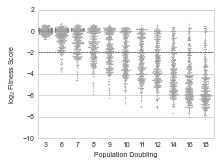

In [27]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (80/25.4, 60/25.4))
plt.rcParams["font.family"] = "Arial"
ax111 = fig.add_subplot(1,1,1)

plt.axhline(y=-2, xmin=0, xmax = 1, linewidth=0.5, color='black', linestyle = '--')
sns.swarmplot(data = [df_sgRNA_counts_LR_withcounts_info_genesEss_groupbyMed_Avg[col] for col in avg_col_names_KD], size = 1,
             color = 'gray', edgecolor = 'gray')

plt.ylim([-10,2])
plt.ylabel(r'log$_2$ Fitness Score', fontsize = 7)
plt.xlabel('Population Doubling', fontsize = 7)
plt.xticks(np.arange(0,11,1), [3,6,7,8,9,10,11,12,14,16,18])
plt.tick_params(axis = 'both', which = 'major', labelsize = 7, length = 0)

plt.savefig('Section 4v2/Fig_4_a-swarmplot_AltColor-Gray.pdf', type = 'pdf')

### Data Export

In [55]:
df_Fig4a = df_sgRNA_counts_LR_withcounts_info_genesEss_groupbyMed_Avg.copy()
df_Fig4a.to_excel('Section 4v2/Table_Fig-4a.xlsx')
df_Fig4a

,gene_name_F2,t3_Avg,t6_Avg,t7_Avg,t8_Avg,t9_Avg,t10_Avg,t11_Avg,t12_Avg,t13_Avg,t14_Avg,t15_Avg
gene_name_F2,,,,,,,,,,,,
accA,accA,0.117025,-0.863486,-1.419859,-2.059128,-2.747263,-3.739926,-4.235603,-4.641903,-5.773142,-6.299523,-7.222530
accB,accB,0.461185,-0.651936,-1.092866,-1.993409,-2.587277,-3.569107,-4.370134,-4.744659,-6.217891,-6.953633,-7.771175
accC,accC,0.154701,-0.877523,-1.444115,-2.215535,-2.778908,-3.228982,-3.402388,-4.042745,-4.985673,-5.365150,-5.736340
accD,accD,0.478765,-0.780270,-1.346958,-2.179807,-3.055462,-3.748451,-5.016987,-4.796926,-6.050413,-6.752917,-7.195682
acpP,acpP,0.008369,-0.717893,-1.229691,-2.193193,-2.826484,-3.714191,-4.613822,-4.676622,-6.300555,-6.960780,-7.647728
...,...,...,...,...,...,...,...,...,...,...,...,...
yihA,yihA,-0.273215,-0.278235,-0.329687,-0.561896,-0.771812,-0.950313,-1.281992,-1.730563,-2.679731,-3.817221,-4.789260
yqgD,yqgD,-0.240749,-0.440849,-0.110940,-0.286474,0.019211,-0.055570,-0.381681,-0.056047,-0.271176,-0.263363,-0.106305
yqgF,yqgF,0.020790,-0.000369,0.089088,0.108736,-0.055860,-0.134294,-0.193389,-0.240484,-0.424501,-0.890069,-1.055907


## Figure 4b

### Visualize

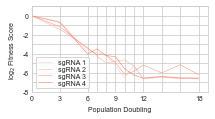

In [29]:
plt.rcParams["font.family"] = "Arial"
sns.set_style('whitegrid', {'font.family': 'Arial'})
gene_name = 'rpsK'
cols_order_KD = cols_order_KD_R1
color_palette = sns.light_palette('#F37560',5)
color_palette = color_palette[1:]

fig = plt.figure(figsize = (80/25.4, 40/25.4))

df_iter = df_sgRNA_counts_LR_withcounts_info.copy()
df_iter = df_iter[df_iter['gene_name_F2'] == gene_name]

i = 0
for guide in df_iter.index:
    ax111 = fig.add_subplot(1,1,1)
    df_plot = df_iter[df_iter['gene_name_F2'] == gene_name][cols_order_KD]
    plt.plot([0,3,6,7,8,9,10,11,12,14,16,18], df_plot.loc[guide][0:len([0,3,6,7,8,9,10,11,12,14,16,18])],
            color = color_palette[i], linewidth = 0.5)
    plt.xticks([0,3,6,7,8,9,10,11,12,14,16,18],[0,3,6,'','',9,'','',12,'','',18])
    plt.yticks([1, 0, -1, -2, -3, -4, -5, -6, -7, -8],['', 0, '', -2, '', -4, '', -6, '', -8]);
    plt.ylim([-8,1])
    plt.xlim([0,19])
    ax111.tick_params(axis = 'y', labelsize = 7)
    ax111.tick_params(axis = 'x', labelsize = 7)
    plt.xlabel('Population Doubling', fontsize = '7')
    plt.ylabel(r'log$_2$ Fitness Score', fontsize = '7')
    plt.legend(['sgRNA 1','sgRNA 2','sgRNA 3','sgRNA 4'], ncol = 1, loc = 'lower left', 
               fontsize = 7, frameon = True, labelspacing = 0.1)
    i += 1
plt.tick_params(length = 0)    
plt.savefig('Section 4v2/Fig_4_b_Early(rpsK)_AltColor2.pdf', type = 'pdf')

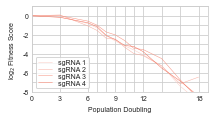

In [30]:
plt.rcParams["font.family"] = "Arial"
sns.set_style('whitegrid', {'font.family': 'Arial'})
gene_name = 'msbA'
cols_order_KD = cols_order_KD_R1

fig = plt.figure(figsize = (80/25.4, 40/25.4))
color_palette = sns.light_palette('#F37560',5)
color_palette = color_palette[1:]

df_iter = df_sgRNA_counts_LR_withcounts_info.copy()
df_iter = df_iter[df_iter['gene_name_F2'] == gene_name]

i = 0
for guide in df_iter.index:
    ax111 = fig.add_subplot(1,1,1)
    df_plot = df_iter[df_iter['gene_name_F2'] == gene_name][cols_order_KD]
    plt.plot([0,3,6,7,8,9,10,11,12,14,16,18], df_plot.loc[guide][0:len([0,3,6,7,8,9,10,11,12,14,16,18])],
            color = color_palette[i], linewidth = 0.5)
    plt.xticks([0,3,6,7,8,9,10,11,12,14,16,18],[0,3,6,'','',9,'','',12,'','',18])
    plt.yticks([1, 0, -1, -2, -3, -4, -5, -6, -7, -8],['', 0, '', -2, '', -4, '', -6, '', -8]);
    plt.ylim([-8,1])
    plt.xlim([0,19])
    ax111.tick_params(axis = 'y', labelsize = 7)
    ax111.tick_params(axis = 'x', labelsize = 7)
    plt.xlabel('Population Doubling', fontsize = '7')
    plt.ylabel(r'log$_2$ Fitness Score', fontsize = '7')
    plt.legend(['sgRNA 1','sgRNA 2','sgRNA 3','sgRNA 4'], ncol = 1, loc = 'lower left', 
               fontsize = 7, frameon = True, labelspacing = 0.1)
    i += 1
plt.tick_params(length = 0)
plt.savefig('Section 4v2/Fig_4_b_Mid(msbA)_AltColor2.pdf', type = 'pdf')

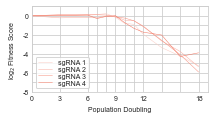

In [31]:
plt.rcParams["font.family"] = "Arial"
sns.set_style('whitegrid', {'font.family': 'Arial'})
gene_name = 'folC'
cols_order_KD = cols_order_KD_R1
plot_color = sns.color_palette('RdBu', 3)[0]

sns.set_style('whitegrid')
fig = plt.figure(figsize = (80/25.4, 40/25.4))
color_palette = sns.light_palette('#F37560',5)
color_palette = color_palette[1:]

df_iter = df_sgRNA_counts_LR_withcounts_info.copy()
df_iter = df_iter[df_iter['gene_name_F2'] == gene_name]

i = 0
for guide in df_iter.index:
    ax111 = fig.add_subplot(1,1,1)
    df_plot = df_iter[df_iter['gene_name_F2'] == gene_name][cols_order_KD]
    plt.plot([0,3,6,7,8,9,10,11,12,14,16,18], df_plot.loc[guide][0:len([0,3,6,7,8,9,10,11,12,14,16,18])],
            color = color_palette[i], linewidth = 0.5)
    plt.xticks([0,3,6,7,8,9,10,11,12,14,16,18],[0,3,6,'','',9,'','',12,'','',18])
    plt.yticks([1, 0, -1, -2, -3, -4, -5, -6, -7, -8],['', 0, '', -2, '', -4, '', -6, '', -8]);
    plt.ylim([-8,1])
    plt.xlim([0,19])
    ax111.tick_params(axis = 'y', labelsize = 7)
    ax111.tick_params(axis = 'x', labelsize = 7)
    plt.xlabel('Population Doubling', fontsize = '7')
    plt.ylabel(r'log$_2$ Fitness Score', fontsize = '7')
    plt.legend(['sgRNA 1','sgRNA 2','sgRNA 3','sgRNA 4'], ncol = 1, loc = 'lower left', 
               fontsize = 7, frameon = True, labelspacing = 0.1)
    i += 1
plt.tick_params(length = 0)    
plt.savefig('Section 4v2/Fig_4_b_Late(folC)_AltColor2.pdf', type = 'pdf')

### Data Export

In [63]:
dict_Fig4b = {}

for gene in ['rpsK', 'msbA','folC']:
    dict_Fig4b[gene] = df_sgRNA_counts_LR_withcounts_info[df_sgRNA_counts_LR_withcounts_info['gene_name_F2'] == gene][['gene_name_F2']+cols_order_KD_R1]
    
df_Fig4b = pd.concat(dict_Fig4b.values(), axis=0)
df_Fig4b.to_excel('Section 4v2/Table_Fig-4b.xlsx')
df_Fig4b

,gene_name_F2,t0_LR,t3_R1_LR,t6_R1_LR,t7_R1_LR,t8_R1_LR,t9_R1_LR,t10_R1_LR,t11_R1_LR,t12_R1_LR,t13_R1_LR,t14_R1_LR,t15_R1_LR
seq,,,,,,,,,,,,,
gagtggatttgcgagaacca,rpsK,0.0,-0.600688,-3.764187,-3.851650,-4.128759,-5.256040,-6.519075,-5.190452,-6.519075,-6.349150,-6.492108,-6.519075
accacggaaaccggaaccac,rpsK,0.0,-1.424603,-3.353637,-4.218707,-4.969748,-4.775101,-4.623098,-5.294475,-6.623098,-6.453173,-6.596131,-6.623098
acgatcagtgatagtcacga,rpsK,0.0,-1.152003,-3.415037,-4.087463,-4.101538,-4.906891,-6.169925,-5.841302,-5.169925,-6.000000,-5.142958,-6.169925
acacgtttacgtgcacgaat,rpsK,0.0,-0.693048,-4.026472,-3.476505,-4.168652,-4.295933,-5.558967,-6.230345,-6.558967,-6.389042,-6.532000,-6.558967
caatggttggccacagtcgg,msbA,0.0,-0.123905,-0.796799,-1.265753,-2.067675,-2.655929,-3.148445,-3.590341,-4.099536,-5.251539,-7.394497,-9.006426
gcgcaatggttggccacagt,msbA,0.0,0.094751,-1.048663,-1.525538,-2.349510,-2.450319,-3.298316,-3.969693,-4.172785,-5.265894,-7.145818,-6.435819
acgatcagacccgctttgaa,msbA,0.0,0.020092,-0.548953,-0.973202,-1.692079,-2.010383,-2.599404,-3.420528,-3.539698,-4.491763,-6.722184,-8.749151
aggtatcgctggctgcgttg,msbA,0.0,-0.153404,-0.722160,-1.133718,-2.055871,-2.500634,-3.106556,-3.228595,-3.763668,-5.486828,-6.852179,-8.464108
taagaaagccacgaagccag,folC,0.0,0.046326,0.057157,0.132215,0.235497,-0.143591,-0.788496,-0.889557,-1.925999,-3.341037,-4.220960,-5.247928
